In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report
from tensorflow.keras import models, layers, regularizers

In [4]:
data_path = r"C:\Users\cmhub\Desktop\network-anomaly-detector-starter\data\MachineLearningCSV\MachineLearningCVE\CICIDS2017_clean_binary.csv"
df = pd.read_csv(data_path)
print(f"Original shape: {df.shape}")

x = df.drop(columns=["Label"])
y = df['Label']

#Training on only benign data (Label == 0)
X_normal = x[y == 0]
X_attack = x[y == 1]

# Splitting the normal data into training and validation sets
X_train, X_test = train_test_split(X_normal, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_attack_scaled = scaler.transform(X_attack)

print(f"Train set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"Attack set shape: {X_attack_scaled.shape}")
# Building the autoencoder model
input_dim = X_train_scaled.shape[1]

autoencoder = models.Sequential([layers.Input(shape=(input_dim,)),
                                 layers.Dense(64, activation='relu', activity_regularizer=regularizers.l1(10e-5)),
                                 layers.Dense(32, activation='relu'),
                                 layers.Dense(16, activation='relu'),
                                 layers.Dense(32, activation='relu'),
                                    layers.Dense(64, activation='relu'),
                                    layers.Dense(input_dim, activation='linear')])
autoencoder.compile(optimizer='adam', loss='mse')

#Training the autoencoder

history = autoencoder.fit(X_train_scaled, X_train_scaled,
                          epochs=30,
                          batch_size=512,
                          validation_data=(X_test_scaled, X_test_scaled), verbose=1
                          )

#Reconstruction error on test set
recon_normal = np.mean(np.square(X_test_scaled - autoencoder.predict(X_test_scaled)), axis=1)
recon_attack = np.mean(np.square(X_attack_scaled - autoencoder.predict(X_attack_scaled)), axis=1)

#Determining the threshold for anomaly detection (95th percentile of reconstruction error on normal data)
threshold = np.percentile(recon_normal, 95)
print(f"Reconstruction error threshold: {threshold:.4f}")

#Classifying based on reconstruction error
y_pred = np.concatenate([np.where(recon_normal > threshold, 1, 0), np.where(recon_attack > threshold, 1, 0)])
y_true = np.concatenate([np.zeros_like(recon_normal), np.ones_like(recon_attack)])

#Evaluating the model
auc = roc_auc_score(y_true, y_pred)
print(f"Autoencoder ROC AUC Score: {auc:.4f}")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly']))

Original shape: (2604998, 79)
Train set shape: (1740303, 78)
Test set shape: (435076, 78)
Attack set shape: (429619, 78)
Epoch 1/30
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.3553 - val_loss: 0.1884
Epoch 2/30
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1761 - val_loss: 0.1208
Epoch 3/30
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1558 - val_loss: 0.1101
Epoch 4/30
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1136 - val_loss: 0.0987
Epoch 5/30
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1015 - val_loss: 0.3262
Epoch 6/30
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1098 - val_loss: 0.0699
Epoch 7/30
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0909 - val_loss: 0.0890
Epoch 8/30
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0794 - val_loss: 0.0607
Epoch 9/30
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.1258 - val_loss: 0.0698
Epoch 10/30
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0889 - val_loss: 0.

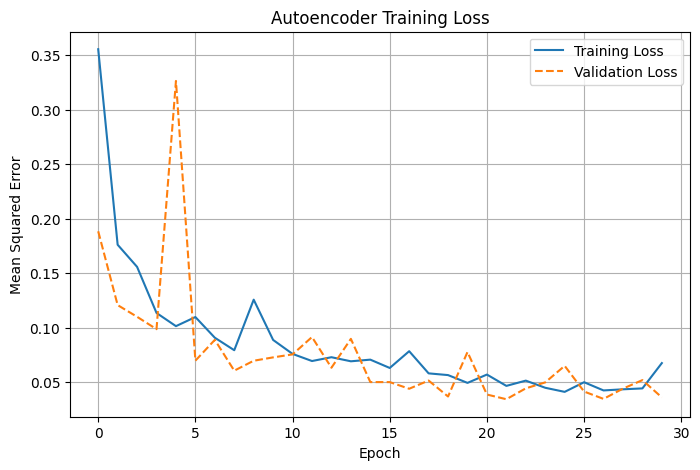

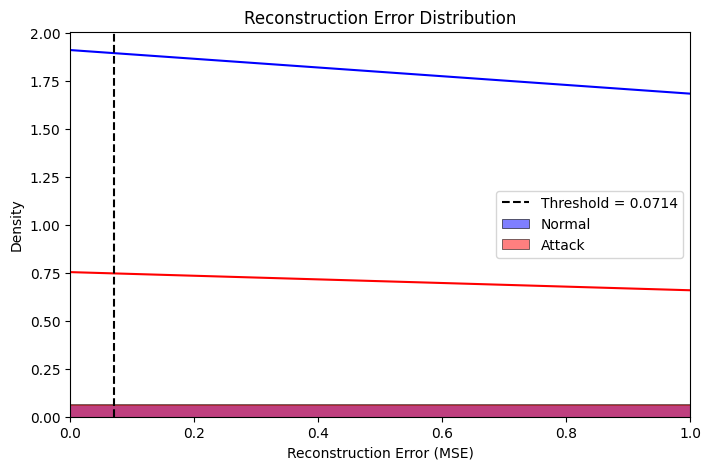

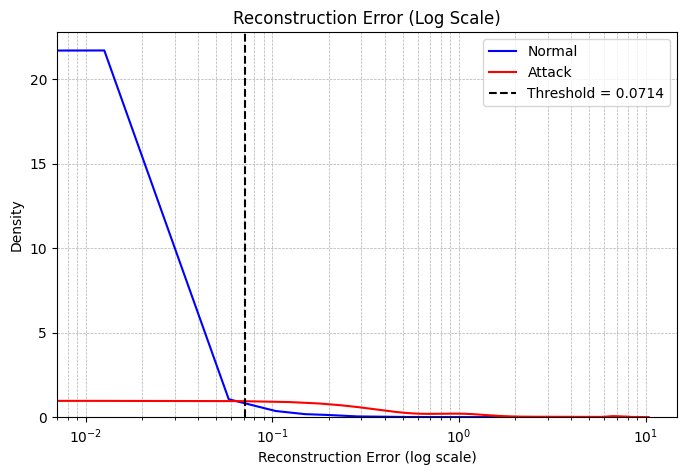

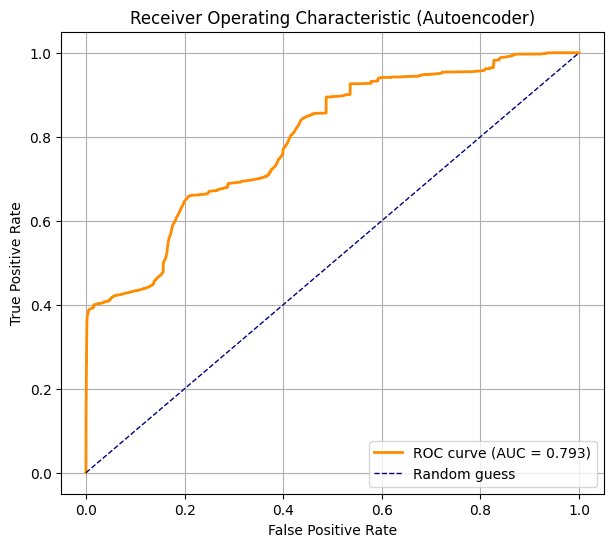

Optimal threshold ≈ 0.01146  | TPR: 0.658  FPR: 0.208


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# 1. Plot training and validation loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.show()

# 2. Plot histogram of reconstruction errors
plt.figure(figsize=(8, 5))
sns.histplot(recon_normal, bins=100, color='blue', label='Normal', stat='density', kde=True)
sns.histplot(recon_attack, bins=100, color='red', label='Attack', stat='density', kde=True)
plt.axvline(threshold, color='black', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.xlim(0, 1)
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Density")
plt.legend()
plt.show()

# 3. Overlay both histograms on log scale
max_val = np.percentile(np.concatenate([recon_normal, recon_attack]), 99)

# Filter out the extremes
recon_normal_trim = recon_normal[recon_normal < max_val]
recon_attack_trim = recon_attack[recon_attack < max_val]

# Create figure
plt.figure(figsize=(8, 5))

# KDE plot for smooth density
sns.kdeplot(recon_normal_trim, color='blue', label='Normal', bw_adjust=1.5)
sns.kdeplot(recon_attack_trim, color='red', label='Attack', bw_adjust=1.5)

# Threshold line
plt.axvline(threshold, color='black', linestyle='--', label=f'Threshold = {threshold:.4f}')

# Logarithmic x-axis for clarity
plt.xscale('log')

# Titles and labels
plt.title("Reconstruction Error (Log Scale)")
plt.xlabel("Reconstruction Error (log scale)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#Computing ROC Curve and AUC from reconstruction errors
# Compute ROC curve and AUC from reconstruction errors
all_errors = np.concatenate([recon_normal, recon_attack])
all_labels = np.concatenate([np.zeros_like(recon_normal), np.ones_like(recon_attack)])

fpr, tpr, thresholds = roc_curve(all_labels, all_errors)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random guess')
plt.title('Receiver Operating Characteristic (Autoencoder)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Find threshold giving best balance (Youden’s J statistic)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
print(f"Optimal threshold ≈ {thresholds[best_idx]:.5f} "
      f" | TPR: {tpr[best_idx]:.3f}  FPR: {fpr[best_idx]:.3f}")
